In [1]:
import numpy as np
import scipy
import scipy.stats as sps
from scipy.stats import gmean
import scipy.optimize as spopt
import matplotlib.pyplot as plt

# Defining functions to use


In [2]:
def sigmas_to_p(sigval):
    nd = sps.norm(0., 1.)
    return 2.*nd.sf(sigval)


def histrebin(mininbin, nbins, emin, emax, array): 
    '''
    Rebins a histogram so there are at least mininbin counts per bin
    Inputs: minimum counts per bin,
            number of bins nbins,
            emin, emax range of x-axis,
            array of values,
    Output: rebined counts and bin edges
    '''
    
    counts, edges = np.histogram(array, bins=nbins, range=[emin,emax], density=False)
    edges_new=np.zeros(1)
    counts_new=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges_new[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  
            # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: 
                # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts_new[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts_new=np.append(counts_new,countsum)
            edges_new=np.append(edges_new,edges[i])
            countsum=0        

    return counts_new, edges_new


def model_int_cf(ecent, ebins, model, *parm): 
    '''
    General function for integrating the input model over energy
    bins ebins, including also a dummy energy bin centres input ecent 
    (which must match the number of bins in array length)
    
    Inputs: bin centers ecent,
            bin edges ebins,
            model and model parameters
    Output: the model y values
    '''
    
    i = 0
    ymod = np.zeros(len(ecent))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = scipy.integrate.quad(lambda x: model(x, parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod


def plgauss_model(value, parm):
    pl_norm = parm[0]  # here the function given means that the normalisation corresponds to that at a value 1.0
    pl_index = parm[1]
    line_en = parm[2]
    line_sig = parm[3]
    line_norm = parm[4]
    # The line is a Gaussian shape with a normalisation equal to the number of counts in the line
    lineflux = np.exp(-0.5*np.power((value - line_en)/line_sig, 2.))/(line_sig*np.sqrt(2.*np.pi))
    return pl_norm * np.power(value,pl_index) + line_norm * lineflux


def gauss_model(value, parm):
    line_en1 = parm[0]
    line_sig1 = parm[1]
    line_norm1 = parm[2]
    backround= parm[3]
    # The line is a Gaussian shape with a normalisation equal to the number of counts in the line
    lineflux1 = np.exp(-0.5*np.power((value - line_en1)/line_sig1, 2.))/(line_sig1*np.sqrt(2.*np.pi))
    return line_norm1 * lineflux1 + backround


def double_gauss_model(value, parm):
    line_en1 = parm[0]
    line_sig1 = parm[1]
    line_norm1 = parm[2]
    line_en2 = parm[3]
    line_sig2 = parm[4]
    line_norm2 = parm[5]
    backround= parm[6]
    # The line is a Gaussian shape with a normalisation equal to the number of counts in the line
    lineflux1 = np.exp(-0.5*np.power((value - line_en1)/line_sig1, 2.))/(line_sig1*np.sqrt(2.*np.pi))
    lineflux2 = np.exp(-0.5*np.power((value - line_en2)/line_sig2, 2.))/(line_sig2*np.sqrt(2.*np.pi))
    return line_norm1 * lineflux1 + line_norm2 * lineflux2 + backround


def plot_spec_model(energies,cdens,cdens_err,cdens_model,ebins):
    
    bwidths = ebins[1:]-ebins[:-1]
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o')
    dummy_data = (ebins[1:]+ebins[:-1])/2
    model_hist, edges, patches = ax1.hist(dummy_data, bins=ebins, weights=cdens_model, 
                                      density=False, histtype='step')
    ax2.errorbar(energies, cdens/cdens_model, xerr=bwidths/2., yerr=cdens_err/cdens_model, fmt='o')
    ax2.set_xlabel("Channel #", fontsize=16)
    ax1.set_ylabel("Density", fontsize=14)
    ax2.set_ylabel("data/model", fontsize=14)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.set_xlim(ebins[0],ebins[-1]) # Strictly speaking we should only show the energy range where data is sampled, 
    # to avoid impression from model that the flux suddenly drops at the boundaries.
    plt.show()
    
    
def grid_search2d_nmchisq(aval,bval,aindex,bindex,parm,model,xval,yval,dy):
    '''
    Inputs: aval is the 1-D grid of parameter values searched over,
            bval is the other 1-D grid of parameter values searched over,
            parm is the array of the other (fitted) parameter's starting values, 
            aindex gives the location to insert the parameter searched over into
            bindex gives the location to insert the other parameter searched over into
            the parameter array for use in the log-likelihood function being evaluated
    Output: 2-D log-likelihood values for the parameter values that are searched over
    '''
    
    llval = np.zeros([len(aval),len(bval)])
    i = -1
    for a in aval:
        i = i + 1
        j = -1
        for b in bval:
            j = j + 1
            llfunc = lambda parm, model, xval, yval, dy: ChiSq(
                np.insert(np.insert(parm,aindex,a),bindex,b),model, xval, yval, dy)
            result = spopt.minimize(llfunc, parm, args=(model, xval, yval, dy), method='Nelder-Mead')
            llval[i,j] = result.fun
    return llval    


def grid_search_nmchisq(aval,aindex,parm,model,xval,yval,dy):
    '''
    Inputs: aval is the 1-D grid of parameter values searched over, 
            parm is the array of the other (fitted) parameter's starting values, 
            aindex gives the location to insert the parameter searched over into 
            the parameter array for use in the log-likelihood function being evaluated
    Output: log-likelihood values for the parameter values that are searched over
    '''
    
    llval = np.zeros(len(aval))
    i = -1
    for a in aval:
        i = i + 1
        llfunc = lambda parm, model, xval, yval, dy: ChiSq(np.insert(parm,aindex,a), model, xval, yval, dy)
        result = spopt.minimize(llfunc, parm, args=(model, xval, yval, dy), method='Nelder-Mead')
        llval[i] = result.fun
    return llval    


def grid_errors(best_a,llmin,aval,llval,dll):
    '''
    Estimates errors corresponding to change in the log-likelihood dll (or weighted least squares)
    Inputs: best-fitting MLE for parameter searched over best_a,
            it's log-likelihood statistic llmin,
            the arrays of parameter searched over aval,
            its corresponding best-fit log-likelihood llval,
            and the delta-ll dll
    Output: [-error,+error]
    
    '''
    
    a_cimin = 1.e12
    a_cimax = -1.e12
    i = -1
    for a in aval:
        i = i + 1
        if llval[i]-llmin <= dll:
            if a < best_a and a < a_cimin:
                a_cimin = a
            if a > best_a and a > a_cimax:
                a_cimax = a
    return np.array([a_cimin-best_a,a_cimax-best_a]) 


def ChiSq_Integ(parm, my_model, ebins, yval, dy): 
    '''
    The weighted least-squares for an array of upper and lower bin edges ebins
    (xval1 and xval2) fitted with the integral over the bin of the model my_model
    '''
    
    i = 0
    ymod = np.zeros(len(yval))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = scipy.integrate.quad(lambda x: my_model(x, parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1

    return sum(pow((yval-ymod)/dy,2))


def LogLikelihood_Pois_Integ(parm, my_model, ebins, yval): 
    '''
    the Poisson log-likelihood for an array 
    of bin edges ebins, fitted with the integral over the bin of the generic model my_model  
    Input yval must be counts and not counts per unit x-value
    '''
    
    i = 0
    ymod = np.zeros(len(yval))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = scipy.integrate.quad(lambda x: my_model(x, parm),ebins[i],ebins[i+1])
        # we don't normalise by bin width since the rate parameter is set by the model and needs to be 
        # in counts per bin
        i=i+1
        
    pd = sps.poisson(ymod) #we define our Poisson distribution

    return -sum(np.log(pd.pmf(yval)))

    
def LogLikelihood(parm, model, xval, yval, dy): 
    '''
    The log-likelihood calculated for a defined model over an array xval
    Inputs: parm, model the model parameters and model respectively
            xval, yval, dy the x-axis, y-axis and y-axis error values respectively
    Output: log liklihood value
    '''
    
    ymod = model(xval, parm)  #We define our 'physical model' separately
    nd = sps.norm(ymod, dy) #we define our normal distribution
    return -sum(nd.logpdf(yval)) # The nd.logpdf may be more accurate than log(nd.pdf) for v. small values


def ChiSq(parm, model, xval, yval, dy): 
    '''
    The weighted least-squares calculated for a defined model over an array xval
    Inputs: parm, model the model parameters and model respectively
            xval, yval, dy the x-axis, y-axis and y-axis error values respectively
    Output: chi-squared value
    '''
    
    ymod = model(xval, parm)
    return sum(pow((yval-ymod)/dy,2))


def plotting_hist(h_array, labels, nbins, emin, emax):
    '''
    Histograms per calibration experiment
    Inputs: h_array is the array of counts per experiment i,
            nbins the number of bins,
            emin, emax the max values of axis x
    '''
    
    fig, axs = plt.subplots(1,len(h_array),figsize=(22,6))
    for i, ax in enumerate(axs):
        ax.hist(h_array[i], bins=nbins, range=[emin,emax], density=False, histtype='step', fill=False)
        ax.set_xlabel("Channel #", fontsize=16)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_title(labels[i], fontsize=16)
        axs[0].set_ylabel("Counts", fontsize=16)
        ax.set_ylim(0.3,300.0)
        ax.set_xlim(10.0,200.0)
        ax.tick_params(labelsize=14)
    return 
        
        
def plotting_rebinned(h_array, labels, cdens, cdens_err, bwidths):
    '''
    Scatter plots of the rebinned data per experiment
    Inputs: h_array is the array of bin centers per experiment i,
            cdens, cdens_err correspond to the channel densities and respective error,
            bwidths to the bin widths
    '''
    
    fig, axs = plt.subplots(1,len(h_array),figsize=(22,6))
    for i, ax in enumerate(axs):
        ax.errorbar(h_array[i], cdens[i], xerr=bwidths[i]/2., yerr=cdens_err[i], fmt='o')
        ax.set_xlabel("Channel #", fontsize=16)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_title(labels[i], fontsize=16)
        axs[0].set_ylabel("Density", fontsize=16)
        ax.set_ylim(0.3,300.0)
        ax.set_xlim(10.0,200.0)
        ax.tick_params(labelsize=14)
    return 


def plotting_chi_squared(x_array, y_array, labels):
    '''
    Multi dimensional plot of the chi-sqared values per parameter and experiment.
    Inputs: x_array corresponds to the array of the parameter values,
            y_array corresponds to the array the chi-squared values per parameter
    '''
    
    ndims = len(x_array)
    fig, axes = plt.subplots(ndims,ndims,figsize=(11,11))
    fig.subplots_adjust(wspace=0.4,hspace=0.6)
    for i in range(ndims): 
        for j in range(ndims):
            if i==0:
                axes[i,j].plot(x_array[i],y_array[i][j])
                axes[i,j].set_title(labels[j])
                axes[i,j].set_xlabel('power law index',fontsize=12)
            elif i==1:
                axes[i,j].plot(x_array[i],y_array[i][j])
                axes[i,j].set_xlabel('channel number',fontsize=12)
            elif i==2:
                axes[i,j].plot(x_array[i],y_array[i][j])
                axes[i,j].set_xlabel('line sigma',fontsize=12)
            elif i==3:
                axes[i,j].plot(x_array[i],y_array[i][j])
                axes[i,j].set_xlabel('line normalization',fontsize=12)

            if j == 0:
                axes[i,j].set_ylabel("$X^{2}$",fontsize=12)   

    plt.show()
    return


def plotting_contours(h_array, Z, mlvals, chisqmin, labels):
    '''
    Corner plot of the calculated contours
    Inputs: h_array corresponds to the array of parameter values, 
            Z the 2-D array calculated from grid_search2d_nmchisq,
            mlvals the maximum likelihood estimations for our parameters,
            chisqmin the minimum chi-squared value calculated from fitting
    '''
    
    ndims = len(h_array)
    fig, axes = plt.subplots(ndims,ndims,figsize=(13,13))
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    
    del1 = sps.chi2.isf(sigmas_to_p(1.0),df=2)
    del2 = sps.chi2.isf(sigmas_to_p(2.0),df=2)
    del3 = sps.chi2.isf(sigmas_to_p(3.0),df=2)
    
    levels = [chsqmin+del1, chsqmin+del2, chsqmin+del3]
    
    for i in range(ndims): 
        for j in range(ndims): 
            if i == j:
                axes[i,j].axis('off')
            elif i > j:
                X, Y = np.meshgrid(h_array[j], h_array[i])
                axes[i,j].contour(X, Y, Z[j,i], levels, colors = ('r', 'g', 'b'))
                axes[i,j].scatter(mlvals[j], mlvals[i], marker="+")
                
            else:
                axes[i,j].axis('off')
            if j == 0:
                if i == j:
                    axes[i,j].axis('off')
                else:
                    axes[i,j].set_ylabel(labels[i],fontsize=13)
            if i == 3:
                axes[i,j].set_xlabel(labels[j],fontsize=13)
    axes[1,0].set_title('Calibration 1 Contours', fontsize=25, pad=40)
    plt.show()
    
    return
    
          
def dataloader():
    '''
    Function that loads the 2 datasets required for this project.
    cal_data corresponds to the data of 4 experiments used for calibration purposes,
    exp_data corresponds to the data used for testing.
    
    Output: cal_data (num_calibrations, length_data),
            exp_data (num_experiments, length_data)
    '''
    
    cal_data = np.genfromtxt('dark_matter_CAL.dat')
    exp_data = np.genfromtxt('dark_matter_EXP.dat')
    

    exp1=cal_data[:,1][cal_data[:,0]==1.]
    exp2=cal_data[:,1][cal_data[:,0]==2.]
    exp3=cal_data[:,1][cal_data[:,0]==3.]
    exp4=cal_data[:,1][cal_data[:,0]==4.]
        
    
    cal_data = np.array([exp1, exp2, exp3, exp4], dtype=object)
    exp_data = exp_data.reshape(1,-1)
    
    return cal_data, exp_data


def model_fitting_cf(channels, new_edges, cdensities, cdens_errs, p, model):
    '''
    Model fitting over a binned array using the scipy curve_fit module. 
    Returns the MLE estimations for parameters cf_pars, covariance matrix err,
    minimum chi squared value minchisq for the best fit, goodness of fit gof.
    
    Inputs: channels correspond to the (rebinned) bin center values,
            new_edges to the bin edges,
            cdens, cdens_err to the channel densities and respective error,
            model, p to the model and model parameters respectively
    Outputs: MLEs, cov matrix, minimum chi-squared, goodness of fit
    '''
    
    ml_cfpars=[]
    ml_cfcovar=[]
    best_model=[]
    minchisq=[]
    err=[]
    cf_pars=[]
    cf_covar=[]
    gof=[]
    
    #each i in channels corresponds to each calibration test 
    #so we loop 4 times (1 per calibration) in order to fit each one
    n = len(channels)

    for i in range(n):
        ecent=channels[i]
        ebins=new_edges[i]
        edens=cdensities[i]
        parms=p[i]

        ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda ecent, *parm: model_int_cf(ecent, ebins, model, *parm),
                                            ecent, edens, parms, sigma=cdens_errs[i])

        cf_pars.append(ml_cfpars)
        cf_covar.append(ml_cfcovar)
        best_model.append(model_int_cf(ecent, ebins, model, *ml_cfpars))
        minchisq.append(np.sum(((edens - best_model[i])/cdens_errs[i])**2.))
        err.append(np.sqrt(np.diag(ml_cfcovar)))
        gof.append(scipy.stats.chi2.sf(minchisq[i],df=(len(edens)-len(parms))))

    return cf_pars, err, minchisq, gof, best_model


def chi_squared(channels, h_array, cdensities, cdens_errs, p, model):
    '''
    Chi-squared calculation for each of the model parameter values, 
    using 1-D grid_search function.
    
    Inputs: channels correspond to the (rebinned) bin center values,
            arrays of parameter values h_array,
            cdens, cdens_err to the channel densities and respective error,
            model, p to the model and model parameters respectively
    Output: 
    '''
    
    pl_indexchisq=[]
    c_numberchisq=[]
    c_sigmachisq=[]
    c_normchisq=[]

    #each i in channels corresponds to each calibration test
    #so we loop 4 times (1 per calibration) in order to fit each one
    n = len(channels)
    for i in range(n):
        xval=channels[i]
        yval=cdensities[i]
        dy=cdens_errs[i]
        aval=h_array


        parm=np.copy(p[i])
        parm1=np.delete(parm, 1) #removing the value searched over each time
        #from the list of model parameters
        pl_indexchisq.append(grid_search_nmchisq(aval[0],1,parm1,model,xval,yval,dy))

        parm=np.copy(p[i])
        parm2=np.delete(parm, 2)
        c_numberchisq.append(grid_search_nmchisq(aval[1],2,parm2,model,xval,yval,dy))

        parm=np.copy(p[i])
        parm3=np.delete(parm, 3)
        c_sigmachisq.append(grid_search_nmchisq(aval[2],3,parm3,model,xval,yval,dy))

        parm=np.copy(p[i])
        parm4=np.delete(parm, 4)
        c_normchisq.append(grid_search_nmchisq(aval[3],4,parm4,model,xval,yval,dy))
        
    return pl_indexchisq, c_numberchisq, c_sigmachisq, c_normchisq


def model_fitting_minimize(channels, cdens, cdens_err, p, model):
    '''
    Model fitting over a binned array using the scipy minimize module. 
    Returns the MLE estimations for parameters _mle,
    minimum chi squared value mlval for the best fit.
    
    Inputs: channels correspond to the (rebinned) bin center values,
            cdens, cdens_err to the channel densities and respective error,
            model, p to the model and model parameters respectively
    Output: MLE value for each model parameter
    '''
    
    result=[]
    mlval=[]
    pl_index_mle=[]
    c_number_mle=[]
    c_sigma_mle=[]
    c_norm_mle=[]
    
    #each i in channels corresponds to each experiment 
    #so we loop 4 times (1 per experiment) in order to fit each one
    n = len(channels)
    for i in range(n):
        xval=channels[i]
        yval=cdens[i]
        dy=cdens_err[i]    
        parm = p[i]
        
        result=( spopt.minimize(ChiSq_Integ, parm, args=(model,xval,yval,dy), method="Nelder-Mead"))
        par1, par2, par3, par4, par5 = result["x"]
        res = result["fun"]
        mlval.append(res)
        pl_index_mle.append(par2)
        c_number_mle.append(par3)
        c_sigma_mle.append(par4)
        c_norm_mle.append(par5)
        
    return pl_index_mle, c_number_mle, c_sigma_mle, c_norm_mle, mlval


def contours(h_array, channels, cdens, cdens_err, p, model):
    '''
    Calculating the 1,2 and 3-sigma contours for a various parameter values stored in h_array.
    
    Inputs: channels correspond to the (rebinned) bin center values,
            cdens, cdens_err to the channel densities and respective error,
            model, p to the model and model parameters respectively
    Output: 2-D chi-squared
    ''' 
    
    xval=channels
    yval=cdens
    dy=cdens_err 
    
    Z = np.zeros((len(h_array), len(h_array), len(h_array[0]), len(h_array[0])))
    for i in range(len(h_array)):
        for j in range(len(h_array)):
            if i != j and i < len(h_array)-1:         
                parm=np.copy(p)
                parm=np.delete(parm, [i+1,j+1])

                Z[i,j] = grid_search2d_nmchisq(h_array[i],h_array[j],i+1,j+1,parm,model,xval,yval,dy)
    return Z

# Data description


In this project, we will analyze simulated data from a hypothetical future experiment to directly detect 
dark matter, via its interactions detected via scintillation, in large tanks of liquid xenon deep underground. The 
detector detects particles or ‘events’ with GeV energies and we aim to find and quantify a pair of signals at 
distinct energies, corresponding to a certain interaction of the dark matter particle. The file with this data from 
the first run of the experiment is the one ending in the suffix ‘…_EXP.dat’. It contains a univariate list of 
the detector channels which each event was recorded to be in. The channel number should scale linearly with 
the energy of the event. 
<br><br>
However, since the detector design is highly novel, to obtain the energy scaling of the channels, we will first 
calibrate the experiment using the data from one of the modules of your detector, which was tested at a 
particle accelerator a few months previously. This calibration data is contained in the file ending in 
‘…_CAL.dat’. The file contains two columns and corresponds to event data from a set of 4 experiments to
check the energy scale. Each row describes one event: the first column gives the number of the experiment
that the event is from, and the second gives the channel (i.e. scaling with the energy) of the event. 
In order to calibrate the channel-to-energy scaling, we assume that the channels correspond to 
contiguous (i.e. adjacent to one another with no gaps) bins of energy, with the lower bound of each channel 
corresponding to an energy $E = kn$ GeV, where n is the channel number (from 0 to 199) and k is the gain of 
the detector, a constant which gives the channel-to-energy scaling. Note that channel numbers < 10 are not 
sensitive to real signals and are already discarded from the data set.


# Loading the data

We proceed to load our available data for manipulation. 
<br>
cal_data corresponds to the 4 experiments used for calibration purposes of the instrument and exp_data to the data of the dark matter experiment.

In [3]:
cal_data, exp_data = dataloader()

# Rebinning

The first step in our analysis is to rebin the data with at least 20 counts per bin in order to get normally distributed errors in each bin.
<br>
That will allow us to employ more fitting methods such as scipy.curve_fit, where normally distributed errors are a requirement.

In [4]:
nbins = 50
emin = 10.0
emax = 200.0
mincounts = 20

bwidths = []
cdens = []
cdens_err = []
channels = []
counts_new = []
edges_new = []

for i in range(len(cal_data)):
    
    counts, edges = histrebin(mincounts, nbins, emin, emax, cal_data[i])
    
    counts_new.append(counts)
    edges_new.append(edges)
    bwidths.append(np.diff(edges_new[i]))
    cdens.append(counts_new[i] / bwidths[i])
    cdens_err.append(np.sqrt(counts_new[i]) / bwidths[i]) 
    channels.append((edges_new[i][:-1]+edges_new[i][1:])/2)

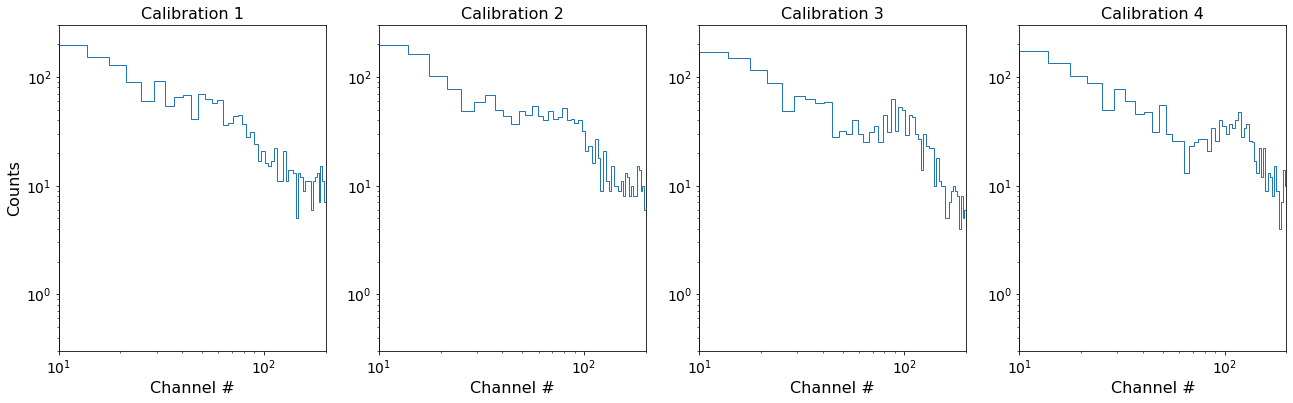

In [5]:
labels = ['Calibration 1', 'Calibration 2', 'Calibration 3', 'Calibration 4']

plotting_hist(cal_data, labels, nbins, emin, emax)

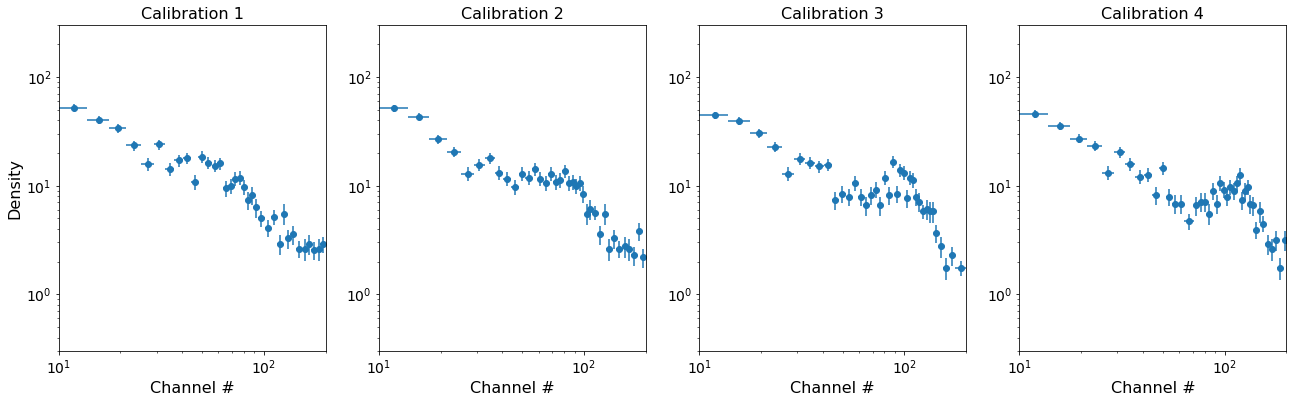

In [6]:
labels = ['Calibration 1', 'Calibration 2', 'Calibration 3', 'Calibration 4']

plotting_rebinned(channels, labels, cdens, cdens_err, bwidths)

Here we do a quick check to make sure the bin errors are normally distributed to use with the curve_fit function. Everything appears to be in order.

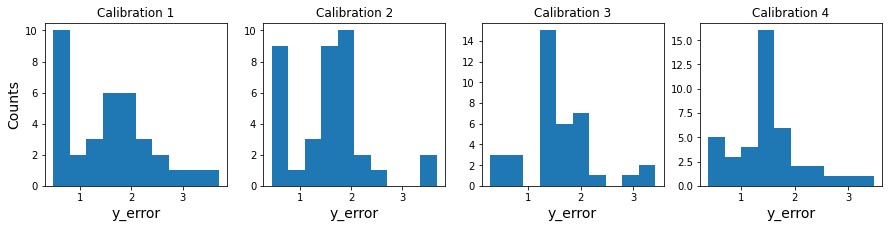

In [7]:
labels = ['Calibration 1', 'Calibration 2', 'Calibration 3', 'Calibration 4']

fig, axs = plt.subplots(1,4, figsize=(15,3))

for i, ax in enumerate(axs):
    ax.hist(cdens_err[i])
    ax.set_xlabel('y_error', fontsize=14)
    axs[0].set_ylabel('Counts', fontsize=14)
    ax.set_title(labels[i])   

# Model fitting with curve_fit

We are now going to use curve_fit and one of the models we have created with our functions to fit tha data for each of the experiments.
<br>
Based on the shape of the data as shown in the plots above, our best guess for a good fit makes use of the plgauss_model assuming a power-law for the continuum and a gaussian for the dark matter emission component which appears to occur in all of the 4 experiments.

In [8]:
#we choose our initial parameters based on good guestimates
p1 = [1000.0, -1.15, 70.0, 20.0, 200.0]
p2 = [1000.0, -1.15, 90.0, 20.0, 200.0]
p3 = [1000.0, -1.15, 110.0, 20.0, 200.0]
p4 = [1000.0, -1.15, 130.0, 20.0, 200.0]
p = np.array([p1, p2, p3, p4])
model = plgauss_model

cf_pars, err, minchisq, gof, best_model = model_fitting_cf(channels, edges_new, cdens, cdens_err, p, model)

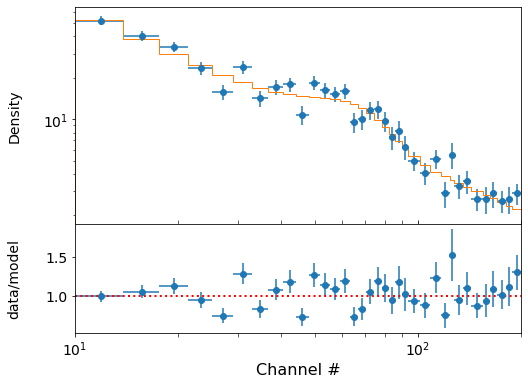

Normalisation value for Calibration 1: 838.791 +/- 124.527
Power-law index for Calibration  1: -1.126 +/- 0.040
Line channel for Calibration  1: 61.469 +/- 3.809
Line width (sigma) for Calibration  1: 16.501 +/- 3.961
Line normalisation for Calibration 1: 222.888 +/- 57.453
Minimum Chi-squared for Calibration  1: 47.696 for 30 d.o.f.
The goodness of fit for Calibration : 1: 0.021
The reduced chi-sqared for Calibration : 1: 1.590
##############################################################################################
##############################################################################################


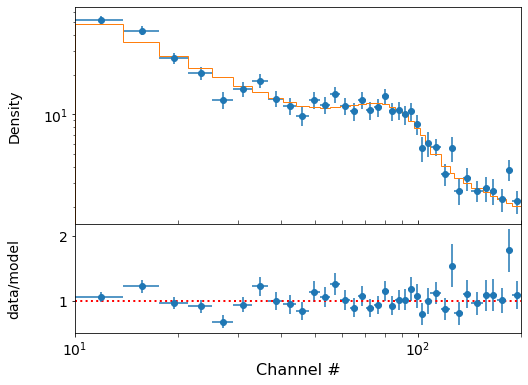

Normalisation value for Calibration 2: 798.509 +/- 119.993
Power-law index for Calibration  2: -1.134 +/- 0.044
Line channel for Calibration  2: 79.198 +/- 2.645
Line width (sigma) for Calibration  2: 18.520 +/- 2.858
Line normalisation for Calibration 2: 297.439 +/- 49.322
Minimum Chi-squared for Calibration  2: 41.904 for 32 d.o.f.
The goodness of fit for Calibration : 2: 0.113
The reduced chi-sqared for Calibration : 2: 1.310
##############################################################################################
##############################################################################################


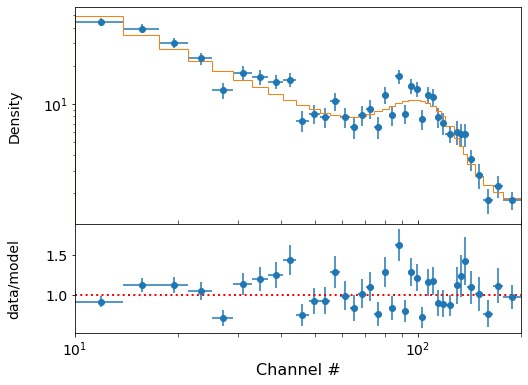

Normalisation value for Calibration 3: 920.505 +/- 191.901
Power-law index for Calibration  3: -1.190 +/- 0.063
Line channel for Calibration  3: 100.822 +/- 2.736
Line width (sigma) for Calibration  3: 20.500 +/- 3.147
Line normalisation for Calibration 3: 359.161 +/- 59.232
Minimum Chi-squared for Calibration  3: 66.012 for 33 d.o.f.
The goodness of fit for Calibration : 3: 0.001
The reduced chi-sqared for Calibration : 3: 2.000
##############################################################################################
##############################################################################################


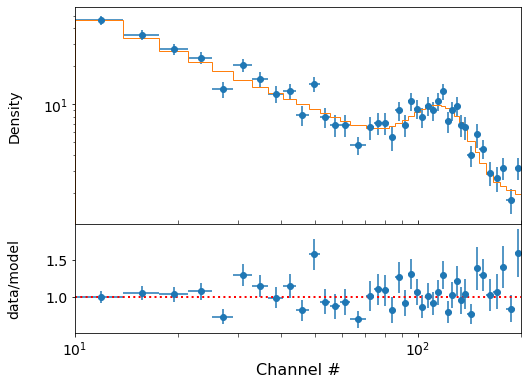

Normalisation value for Calibration 4: 728.489 +/- 139.518
Power-law index for Calibration  4: -1.120 +/- 0.056
Line channel for Calibration  4: 115.786 +/- 2.452
Line width (sigma) for Calibration  4: 19.272 +/- 2.789
Line normalisation for Calibration 4: 306.121 +/- 47.440
Minimum Chi-squared for Calibration  4: 55.950 for 36 d.o.f.
The goodness of fit for Calibration : 4: 0.018
The reduced chi-sqared for Calibration : 4: 1.554
##############################################################################################
##############################################################################################


In [9]:
for i in range(4): 
    
    plot_spec_model(channels[i],cdens[i],cdens_err[i],best_model[i],edges_new[i])
    print("Normalisation value for Calibration "+ str(i+1) + ': ' + "%.3f" %(cf_pars[i][0]) + " +/- " + "%.3f" %(err[i][0]))
    print("Power-law index for Calibration  "+ str(i+1) + ': ' + "%.3f" %(cf_pars[i][1]) + " +/- " + "%.3f" %(err[i][1]))
    print("Line channel for Calibration  "+ str(i+1) + ': ' + "%.3f" %(cf_pars[i][2]) + " +/- " + "%.3f" %(err[i][2]))
    print("Line width (sigma) for Calibration  "+ str(i+1) + ': ' + "%.3f" %(cf_pars[i][3]) + " +/- " + "%.3f" %(err[i][3]))
    print("Line normalisation for Calibration "+ str(i+1) + ': ' + "%.3f" %(cf_pars[i][4]) + " +/- " + "%.3f" %(err[i][4]))
    print("Minimum Chi-squared for Calibration  "+ str(i+1) + ': '  + "%.3f" %(minchisq[i]) + " for "
          + str(len(cdens[i])-len(p[i])) + " d.o.f.")
    print("The goodness of fit for Calibration : "+ str(i+1) + ': ' + "%.3f" %(gof[i]))
    print("The reduced chi-sqared for Calibration : "+ str(i+1) + ': ' + "%.3f" %(minchisq[i]/(len(cdens[i])-len(p[i]))))
    print('##############################################################################################')
    print('##############################################################################################')

# Estimation of ${\chi}^2$ values for each of our model parameters.

We go on to estimate the ${\chi}^2$ for each parameter using a 1-D grid search to get a better overview. 

In [10]:
#setting our initial parameter and array values for modelling

pl_indexval=np.linspace(-1.5,-0.8,100)
c_numberval=np.linspace(50,150,100)
c_sigmaval=np.linspace(10,30,100)
c_normval=np.linspace(50,400,100)

x_array = np.array([pl_indexval, c_numberval, c_sigmaval, c_normval])

p1 = [1000.0, -1.15, 70.0, 20.0, 200.0]
p2 = [1000.0, -1.15, 90.0, 20.0, 200.0]
p3 = [1000.0, -1.15, 110.0, 20.0, 200.0]
p4 = [1000.0, -1.15, 130.0, 20.0, 200.0]

p = np.array([p1, p2, p3, p4])

model = plgauss_model

In [11]:
pl_indexchisq, c_numberchisq, c_sigmachisq, c_normchisq = chi_squared(channels, x_array, cdens, cdens_err, p, model)

We see in our plots below the minima in ${\chi}^2$  per experiment and parameter, corresponding to our curve_fit parameters.

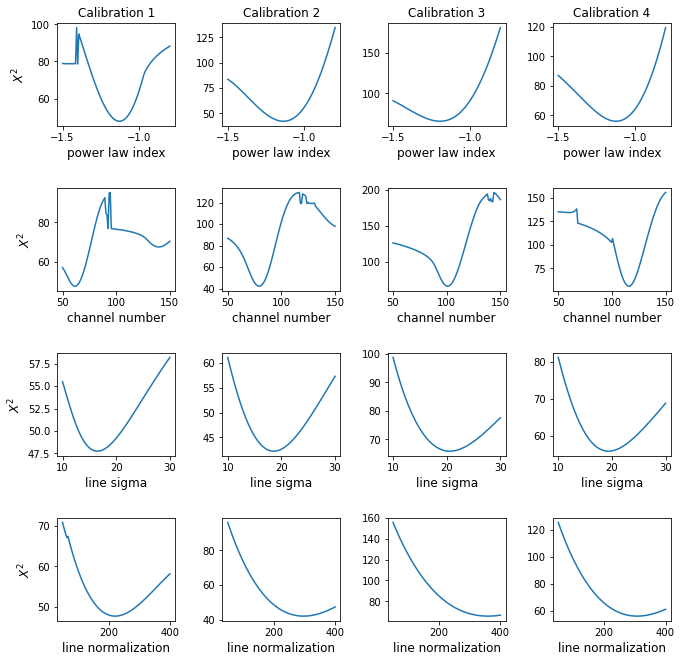

In [12]:
labels = ['Calibration 1', 'Calibration 2', 'Calibration 3', 'Calibration 4']

y_array = np.array([pl_indexchisq, c_numberchisq, c_sigmachisq, c_normchisq])
plotting_chi_squared(x_array, y_array, labels)

# MLE estimation using minimize module

Another alternative for maximum likelihood estimates (MLEs) for our model is the minimize module.
<br>
It has more relaxed requirements compared to curve_fit, so it can be used in situation where curve_fit is obsolete.

In [13]:
pl_index_mle, c_number_mle, c_sigma_mle, c_norm_mle, mlval = model_fitting_minimize(channels, cdens, cdens_err, p, model)

## Error Estimation

We got the errors for the curve_fit model from the estimated covariance matrix. Here we opt to use the more robust grid_errors method for error estimation. Grid_errors will use the MLE values constrained from minimize to explore the ${\chi}^2$ parameter space.
<br>
<br>
We immediately see that both the minimum ${\chi}^2$ and the reduced ${\chi}^2$ with the minimize module are much larger than the corresponding values estimated using curve_fit. For that reason, we will opt to use the curve_fit results further down in our analysis.

In [14]:
pl_error=[]
c_number_error=[]
c_sigma_error=[]
c_norm_error=[] 
     
for i in range(4):  
    

    pl_error.append(grid_errors(pl_index_mle[i],mlval[i],pl_indexval,pl_indexchisq[i],dll=1.0))
    c_number_error.append(grid_errors(c_number_mle[i],mlval[i],c_numberval,c_numberchisq[i],dll=1.0))
    c_sigma_error.append(grid_errors(c_sigma_mle[i],mlval[i],c_sigmaval,c_sigmachisq[i],dll=1.0))
    c_norm_error.append(grid_errors(c_norm_mle[i],mlval[i],c_normval,c_normchisq[i],dll=1.0))
    
    print("Power-law MLE for Calibration  ", i+1,':', "%.3f" %pl_index_mle[i],"-/+", np.round(pl_error[i], 3))
    print("Line channel MLE for Calibration  ", i+1,':', "%.3f" %c_number_mle[i],"-/+", np.round(c_number_error[i], 3))
    print("Line width MLE for Calibration  ", i+1,':', "%.3f" %c_sigma_mle[i],"-/+", np.round(c_sigma_error[i], 3))
    print("Line normalization MLE for Calibration  ", i+1,':', "%.3f" %c_norm_mle[i],"-/+", np.round(c_norm_error[i], 3))
    print("Minimum Chi-squared for Calibration  "+ str(i+1) + ': '  + "%.3f" %(mlval[i]) + " for " 
          + str(len(cdens[i])-len(p[i])) + " d.o.f.")
    print("The reduced chi-sqared for Calibration : "+ str(i+1) + ': ' + "%.3f" %(mlval[i]/(len(cdens[i])-len(p[i]))))
    print('##############################################################################################')
    print('##############################################################################################')
    

Power-law MLE for Calibration   1 : -1.187 -/+ [-0.313  0.273]
Line channel MLE for Calibration   1 : 64.434 -/+ [-14.434  85.566]
Line width MLE for Calibration   1 : 16.509 -/+ [-6.509 13.491]
Line normalization MLE for Calibration   1 : 213.139 -/+ [-163.139  186.861]
Minimum Chi-squared for Calibration  1: 79.693 for 30 d.o.f.
The reduced chi-sqared for Calibration : 1: 2.656
##############################################################################################
##############################################################################################
Power-law MLE for Calibration   2 : -1.186 -/+ [-0.215  0.237]
Line channel MLE for Calibration   2 : 81.864 -/+ [-17.722   9.55 ]
Line width MLE for Calibration   2 : 18.584 -/+ [-8.584 11.416]
Line normalization MLE for Calibration   2 : 292.038 -/+ [-185.472  107.962]
Minimum Chi-squared for Calibration  2: 70.651 for 32 d.o.f.
The reduced chi-sqared for Calibration : 2: 2.208
############################################

# Contours

Another useful visualization of the parameter space of our model and the associated errors are the 2-D contours.
<br>
To determine the 1,2, and 3-sigma region of the contours we perform a 2-D grid search between the 2 parameters of interest each time. We then plot the contours and the MLE from our curve_fit model as a cross. We only do this procedure for the first experiment, as it is time consuming and computationally expensive.
<br><br>
Most of the MLEs from curve_fit appear to lie in the center of the contours as one would expect. However, in some cases, especially the power law index, the MLEs lie within the 2-sigma region instead. As we already saw with the case of 1-D grid search with minimize module, power law index seems to be overestimated. That could potentially explain this discrepancy.


In [15]:
#fine tuning the parameter arrays and values for better visualization of contours

pl_indexval_cont=np.linspace(-1.35,-1.0,20)
c_numberval_cont=np.linspace(40,85,20)
c_sigmaval_cont=np.linspace(10,25,20)
c_normval_cont=np.linspace(100,350,20)


p1_cont = np.array([1000.0, -1.15, 60.0, 15.0, 200.0])


cont_array = np.array([pl_indexval_cont, c_numberval_cont, c_sigmaval_cont, c_normval_cont])

# index 0 to denote the first calibration experiment in our arrays
Z = contours(cont_array, channels[0], cdens[0], cdens_err[0], p1_cont, model)

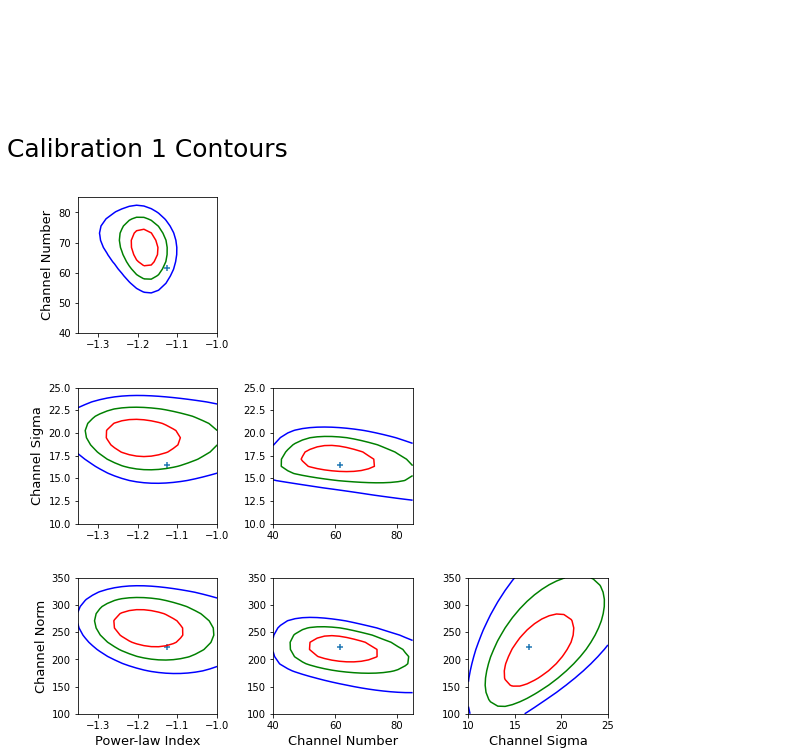

In [16]:
labels = ['Power-law Index', 'Channel Number', 'Channel Sigma', 'Channel Norm']

#we plot the MLEs from curve_fit instead of the minimize module
#as they are the better constrained ones

mle_vals = np.array([cf_pars[0][1], cf_pars[0][2], cf_pars[0][3], cf_pars[0][4]])
chsqmin = minchisq[0]


plotting_contours(cont_array, Z, mle_vals, chsqmin, labels)

# Determining the channel gain k parameter

To do that we will model the relation $E = kn$ where E is the centroid energy of the gaussian peak (given), k the gain of the detector and n the channel number corresponding to the gaussian centroid (our line channel parameter), using a linear fit to determine the gain k of the detector.

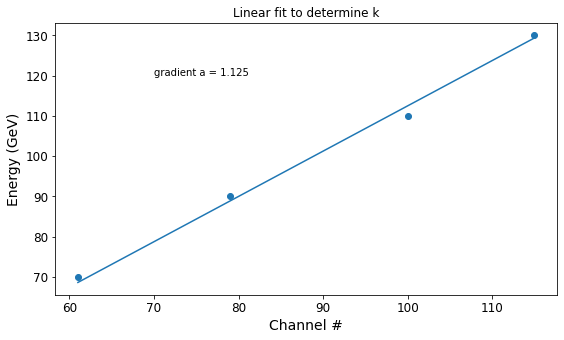

In [17]:
x = np.array([int(cf_pars[0][2]),int(cf_pars[1][2]),int(cf_pars[2][2]),int(cf_pars[3][2])]) #our model parameters from curve_fit
y = [70,90,110,130] #the given parameters for gaussian centroid energy in GeV for each experiment

func = lambda x, a: x*a   #the linear fit 
r2, pcov = spopt.curve_fit(func, x,y, p0=(0))


plt.figure(figsize=(9,5))
plt.scatter(x,y)
plt.plot(x,r2[0]*x)
plt.xlabel("Channel #", fontsize=14)
plt.ylabel("Energy (GeV)", fontsize=14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.text(70,120,'gradient a = %a' %round(r2[0],3))
plt.title('Linear fit to determine k')
plt.show()


# Examination of Dark Matter experiment data


We start by plotting a simple histogram to get an idea of what our data looks like.

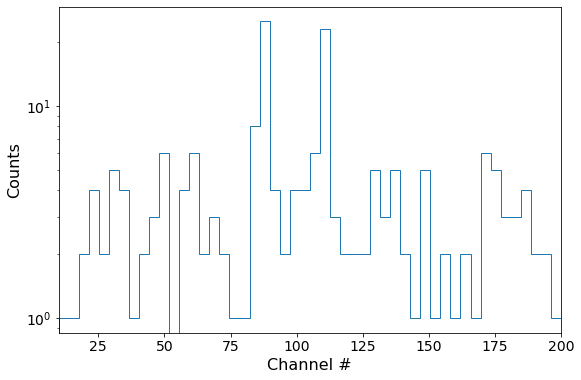

In [18]:
nbins = 50
emin=10.0
emax=200.0

plt.figure(figsize=(9,6))
plt.hist(exp_data[0], bins=50, range=[emin,emax], density=False, histtype='step', fill=False)
plt.xlabel("Channel #", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.yscale('log')
# plt.xscale('log')
plt.tick_params(labelsize=14)
# plt.ylim(0.3,200.0)
plt.xlim(10.0,200.0)
plt.show()

As we did with the calibration experiments, we rebin the data so we have at least 20 counts per bin to get normally distributed errors, as the curve_fit requires.
<br>
We then plot the rebinned data.

In [19]:
#rebinning the same way we did the calibration experiments

mincounts = 20
bwidths_exp = []
cdens_exp = []
cdens_err_exp = []
channels_exp = []
counts_new_exp = []
edges_new_exp = []

for i in range(len(exp_data)):
    
    counts, edges = histrebin(mincounts, nbins, emin, emax, exp_data[i])
    
    counts_new_exp.append(counts)
    edges_new_exp.append(edges)
    bwidths_exp.append(np.diff(edges_new_exp[i]))
    cdens_exp.append(counts_new_exp[i] / bwidths_exp[i])
    cdens_err_exp.append(np.sqrt(counts_new_exp[i]) / bwidths_exp[i]) 
    channels_exp.append((edges_new_exp[i][:-1]+edges_new_exp[i][1:])/2)

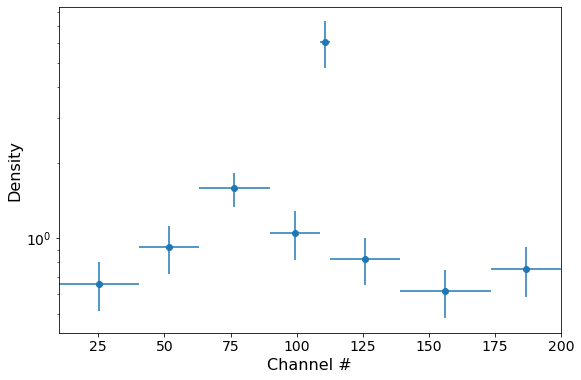

In [20]:
plt.figure(figsize=(9,6))
plt.errorbar(channels_exp[0], cdens_exp[0], xerr=bwidths_exp[0]/2., yerr=cdens_err_exp[0], fmt='o')
plt.xlabel("Channel #", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.tick_params(labelsize=14)
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0.3,200.0)
plt.xlim(10.0,200.0)
plt.show()      

# Model Fitting using curve_fit


For better comparison, we try 3 different fits for our data. 
<br>
First we fit a single gaussian to our data, setting the initial parameter peak around channel 85.
<br>
Then we repeat the same fit but now instead set the peak parameter around channel 110.
<br>
Finally, we fit a double gaussian model to account for both apparent peaks in our data, combining the initial parameters of our separate models.
<br><br>
Based on the fitting results, the single fit models are comparable with reduced ${\chi}^2$ values of 4.457 and 3.373 for single peak 1 and 2 models respectively. The values are too high for either of these models to be acceptable.
<br>
For the double peak model we observe a significant improvement with reduced ${\chi}^2$ value of 0.414 and a goodness of fit of 0.520. Hoever the model appears to be doing poorly on error estimation especially for the first peak parameters, comparerd to the single peak models.

## Single Peak Gaussian 1

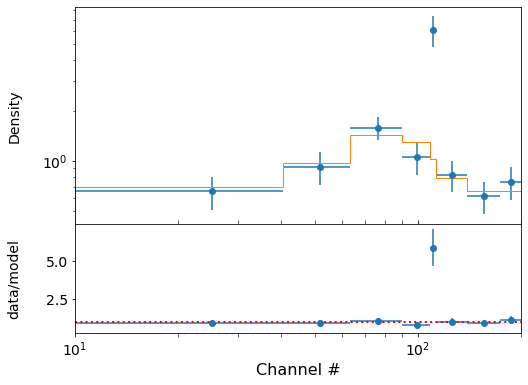

Peak1_channel = 82.799 +/- 13.607
Peak1_width  = 21.450 +/- 16.877
Peak1_norm = 46.258 +/- 35.771
Minimum Chi-squared = 17.827 for 4 d.o.f.
The reduced chi-sqared = 4.457
The goodness of fit is: 0.001


In [21]:
p0_peak1 = [85.0, 5.0, 0.0,0.3]
p_exp = [p0_peak1]
model = gauss_model


cf_pars_exp, err_exp, minchisq_exp, gof_exp, best_model_exp = model_fitting_cf(channels_exp, edges_new_exp, 
                                                                            cdens_exp, cdens_err_exp, p_exp, model)


for i in range(len(exp_data)):

    plot_spec_model(channels_exp[i],cdens_exp[i],cdens_err_exp[i],best_model_exp[i],edges_new_exp[i])
    
    print("Peak1_channel = " + "%.3f" %cf_pars_exp[i][0] + " +/- " + "%.3f" %(err_exp[i][0]))
    print("Peak1_width  = " + "%.3f" %(cf_pars_exp[i][1]) + " +/- " + "%.3f" %(err_exp[i][1]))
    print("Peak1_norm = " + "%.3f" %(cf_pars_exp[i][2]) + " +/- " + "%.3f" %(err_exp[i][2]))
    print("Minimum Chi-squared = " + "%.3f" %(minchisq_exp[i]) + " for " + str(len(cdens_exp[i])-len(p_exp[i])) + " d.o.f.")
    print("The reduced chi-sqared = " + "%.3f" %(minchisq_exp[i]/(len(cdens_exp[i])-len(p_exp[i]))))
    print("The goodness of fit is: " + "%.3f" %(scipy.stats.chi2.sf(minchisq_exp[i],df=(len(cdens_exp[i])-len(p_exp[i])))))

## Single Peak Gaussian 2

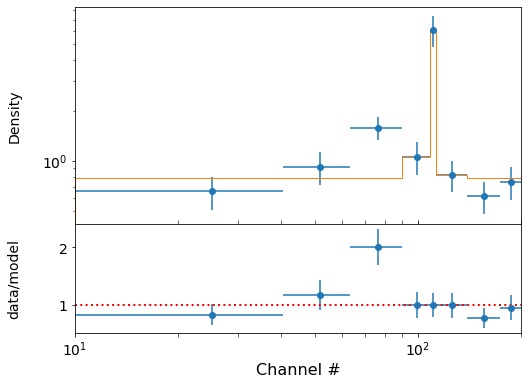

Peak2_channel = 110.066 +/- 2.248
Peak2_width  = 1.464 +/- 2.133
Peak2_norm = 26.172 +/- 16.286
Minimum Chi-squared = 13.491 for 4 d.o.f.
The reduced chi-sqared = 3.373
The goodness of fit is: 0.009


In [22]:
p0_peak2 = [110.0, 5.0 , 0.0, 0.3]
p_exp = [p0_peak2]
model = gauss_model


cf_pars_exp, err_exp, minchisq_exp, gof_exp, best_model_exp = model_fitting_cf(channels_exp, edges_new_exp, 
                                                                            cdens_exp, cdens_err_exp, p_exp, model)


for i in range(len(exp_data)):

    plot_spec_model(channels_exp[i],cdens_exp[i],cdens_err_exp[i],best_model_exp[i],edges_new_exp[i])
    
    
    print("Peak2_channel = " + "%.3f" %(cf_pars_exp[i][0]) + " +/- " + "%.3f" %(err_exp[i][0]))
    print("Peak2_width  = " + "%.3f" %(cf_pars_exp[i][1]) + " +/- " + "%.3f" %(err_exp[i][1]))
    print("Peak2_norm = " + "%.3f" %(cf_pars_exp[i][2]) + " +/- " + "%.3f" %(err_exp[i][2]))
    print("Minimum Chi-squared = " + "%.3f" %(minchisq_exp[i]) + " for " + str(len(cdens_exp[i])-len(p_exp[i])) + " d.o.f.")
    print("The reduced chi-sqared = " + "%.3f" %(minchisq_exp[i]/(len(cdens_exp[i])-len(p_exp[i]))))
    print("The goodness of fit is: " + "%.3f" %(scipy.stats.chi2.sf(minchisq_exp[i],df=(len(cdens_exp[i])-len(p_exp[i])))))

## Double Peak Gaussian

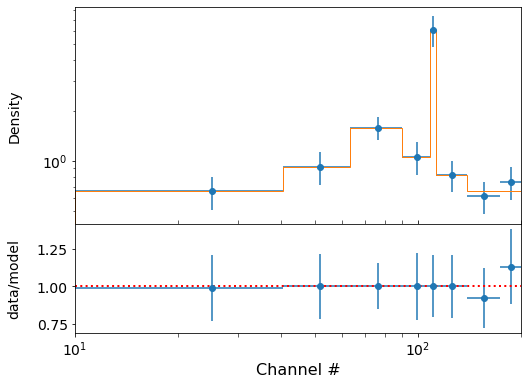

Peak1_channel = 66.799 +/- 11391144.684
Peak1_width  = 4.168 +/- 13192055.011
Peak1_norm = 30.183 +/- 454.452
Peak2_channel = 110.325 +/- 50.827
Peak2_width  = 2.058 +/- 29.673
Peak2_norm = 32.183 +/- 446.335
Peak1_energy = 75.138 GeV
Peak2_energy = 124.098 GeV
Minimum Chi-squared = 0.414 for 1 d.o.f.
The reduced chi-sqared = 0.414
The goodness of fit is: 0.520


In [23]:
p0 = [85.0, 5.0, 0.0, 110.0, 5.0 , 0.0, 0.3]
p_exp=[p0]
model = double_gauss_model


cf_pars_exp, err_exp, minchisq_exp, gof_exp, best_model_exp = model_fitting_cf(channels_exp, edges_new_exp, 
                                                                            cdens_exp, cdens_err_exp, p_exp, model)


for i in range(len(exp_data)):

    plot_spec_model(channels_exp[i],cdens_exp[i],cdens_err_exp[i],best_model_exp[i],edges_new_exp[i])
    
    print("Peak1_channel = " + "%.3f" %cf_pars_exp[i][0] + " +/- " + "%.3f" %(err_exp[i][0]))
    print("Peak1_width  = " + "%.3f" %(cf_pars_exp[i][1]) + " +/- " + "%.3f" %(err_exp[i][1]))
    print("Peak1_norm = " + "%.3f" %(cf_pars_exp[i][2]) + " +/- " + "%.3f" %(err_exp[i][2]))
    print("Peak2_channel = " + "%.3f" %(cf_pars_exp[i][3]) + " +/- " + "%.3f" %(err_exp[i][3]))
    print("Peak2_width  = " + "%.3f" %(cf_pars_exp[i][4]) + " +/- " + "%.3f" %(err_exp[i][4]))
    print("Peak2_norm = " + "%.3f" %(cf_pars_exp[i][5]) + " +/- " + "%.3f" %(err_exp[i][5]))
    print("Peak1_energy = " + "%.3f" %((cf_pars_exp[i][0])*r2[0]) + " GeV")
    print("Peak2_energy = " + "%.3f" %((cf_pars_exp[i][3])*r2[0]) + " GeV")
    print("Minimum Chi-squared = " + "%.3f" %(minchisq_exp[i]) + " for " + str(len(cdens_exp[i])-len(p_exp[i])) + " d.o.f.")
    print("The reduced chi-sqared = " + "%.3f" %(minchisq_exp[i]/(len(cdens_exp[i])-len(p_exp[i]))))
    print("The goodness of fit is: " + "%.3f" %(scipy.stats.chi2.sf(minchisq_exp[i],df=(len(cdens_exp[i])-len(p_exp[i])))))

# Confidence intervals
Estimating confidence intervals for the geometric mean of the gaussian centroid peak values.
<en>
We first calculate the geometric mean of the peaks from the double gauss model, compairing that to the simulated distribution of geometric mean values, generated by bootstrapping.

In [ ]:
peak1_en = cf_pars_exp[0][0] * r2[0] #switching from channel to energy using 
peak2_en = cf_pars_exp[0][3] * r2[0] #the gradient value constrained from linear fit

g_mean_calc = gmean([peak1_en,peak2_en]) #direct calculation of geometric mean from model values

In [ ]:
#bootstrapping to get the g_mean distribution

ntrials = np.geomspace(10,1e5,10000,dtype=int) #number of trials

# Set up the array to record the differences
g_mean = np.zeros(len(ntrials))

for i, N in enumerate(ntrials):
   
    x1 = sps.norm.rvs(loc=peak1_en,scale=cf_pars_exp[0][1],size=(1)) #drawing a sample from normal distributions of 
    x2 = sps.norm.rvs(loc=peak2_en,scale=cf_pars_exp[0][4],size=(1)) #mu and sigma equal to the ones estimated by the model
    g_mean[i] = gmean([x1,x2])  #then calculating the geometric mean for each sample

The distribution of the geometric means for n = 10000 trials, using the values generated by our model fitting
Destribution approaches a normal with mean: 96.521 and standard deviation: 2.784
68% confidence interval: [93.752 99.289]
95% confidence interval: [ 91.065 101.977]
99.7% confidence interval: [ 88.26  104.782]


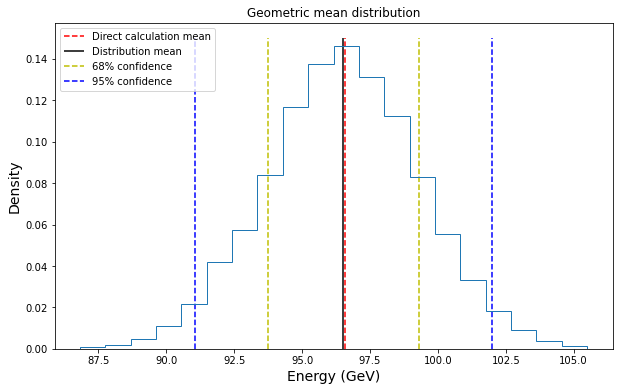

In [24]:
conf_68 = np.round(sps.norm.interval(0.68,loc=np.mean(g_mean),scale=np.std(g_mean)), 3)
conf_95 = np.round(sps.norm.interval(0.95,loc=np.mean(g_mean),scale=np.std(g_mean)), 3)
conf_99 = np.round(sps.norm.interval(0.997,loc=np.mean(g_mean),scale=np.std(g_mean)), 3)


print(f'The distribution of the geometric means for n = {len(ntrials)} trials, using the values generated by our model fitting')
print('Destribution approaches a normal with mean:',"%.3f" %np.mean(g_mean), 'and standard deviation:', "%.3f" %np.std(g_mean))
print('68% confidence interval:',  conf_68) 
print('95% confidence interval:', conf_95)
print('99.7% confidence interval:', conf_99)


plt.figure(figsize=(10,6))
plt.hist(g_mean, bins=20, density=True, histtype='step')
plt.vlines(g_mean_calc, 0, 0.15, linestyle='--' , color='r', label='Direct calculation mean')
plt.vlines(np.mean(g_mean), 0, 0.15, linestyle='-' , color='k', label='Distribution mean')
plt.vlines(conf_68, 0, 0.15, linestyle='--' , color='y', label='68% confidence')
plt.vlines(conf_95, 0, 0.15, linestyle='--' , color='b', label='95% confidence')
plt.xlabel('Energy (GeV)',fontsize=14)
plt.title('Geometric mean distribution')
plt.legend(loc=2)
plt.ylabel('Density',fontsize=14)
plt.show()